In [1]:
pwd

'C:\\Users\\user'

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

tf.config.list_physical_devices('GPU')

Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [185]:
import time
import sys
import datetime
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import tensorflow as tf
import cv2
import seaborn as sns
from tensorboard import notebook
%load_ext tensorboard

from skimage import exposure
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.utils.layer_utils import count_params

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [4]:
# Define Image Augmentation and Training Parameters

class Config:
    # Data Augmentation Parameters
    DATA_AUG_ON = False
    DATA_AUG_ROTATE = 40
    DATA_AUG_FLIP = True
    DATA_AUG_WIDTH_SHIFT = 0.2
    DATA_AUG_HEIGHT_SHIFT = 0.2
    DATA_AUG_ZOOM = 0.2
    DATA_AUG_SHEAR = 0.2
    # Epoch to start learning rate decay
    MODEL_TRAIN_DECAY = True
    MODEL_START_DECAY = 1
    # Exponential Learning Rate Decay
    MODEL_DECAY_EXPONENTIAL = True
    MODEL_PERCENT_DECAY = 0.1
    # Drop-Based Learning Rate Decay
    MODEL_DECAY_DROP = False
    MODEL_DROP_RATE = 0.5
    MODEL_EPOCH_DROP = 10
    # General Model Parameters
    MODEL_TRAIN_EPOCHS = [30]
    MODEL_TRAIN_LEARN_RATE = [0.01]
    MODEL_TRAIN_BATCH_SIZE = 32
    MODEL_TRAIN_FIRST_TRAINABLE_LAYER = 50
    
config = Config()

In [5]:
# Define Base Model

base_model = InceptionV3(weights = 'imagenet', include_top = False)

MODEL_TRAINABLE_BASE = True

if MODEL_TRAINABLE_BASE:
    base_model.trainable = True
    if config.MODEL_TRAIN_FIRST_TRAINABLE_LAYER:
        for layer in base_model.layers[:config.MODEL_TRAIN_FIRST_TRAINABLE_LAYER]:
            layer.trainable = False
        for layer in base_model.layers[config.MODEL_TRAIN_FIRST_TRAINABLE_LAYER:]:
            layer.trainable = True
else:
    base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(64, activation = 'relu', kernel_regularizer = regularizers.l2(5e-3),
                bias_regularizer = regularizers.l2(5e-3))(x)
x = Dense(1, activation = 'sigmoid', name = 'output')(x)

model = Model(inputs = base_model.input, outputs = x)

# print(model.summary())

trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)
print('Total Parameters: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable Parameters: {:,}'.format(trainable_count))
print('Non-Trainable Parameters: {:,}'.format(non_trainable_count))

Total Parameters: 21,942,177
Trainable Parameters: 21,391,761
Non-Trainable Parameters: 550,416


In [6]:
# # Image Augmentation Parameters

# datagen = ImageDataGenerator(rescale = 1./255.,
#                              rotation_range = config.DATA_AUG_ROTATE,
#                              horizontal_flip = config.DATA_AUG_FLIP,
#                              width_shift_range = config.DATA_AUG_WIDTH_SHIFT,
#                              height_shift_range = config.DATA_AUG_HEIGHT_SHIFT,
#                              zoom_range = config.DATA_AUG_ZOOM,
#                              shear_range = config.DATA_AUG_SHEAR)

# images = 'E:\\video_unique\\in'
# output = 'E:\\video_unique'

# for filenames in os.listdir(images)[:2]:
#     img = load_img(os.path.join(images, filenames))
#     x = img_to_array(img)
#     x = x.reshape((1,) + x.shape)
    
#     i = 1
#     for batch in datagen.flow(x,
#                               batch_size = 1,
#                               save_to_dir = output,
#                               save_prefix = 'in',
#                               save_format = 'jpeg'):
#         i += 1
#         if i > 3:
#             print(i)
#             break

In [99]:
if config.DATA_AUG_ON:
    train_datagen = ImageDataGenerator(# preprocessing_function = preprocess_input,
                                       rescale = 1./255.,
                                       validation_split = 0.2,
                                       rotation_range = config.DATA_AUG_ROTATE,
                                       horizontal_flip = config.DATA_AUG_FLIP,
                                       width_shift_range = config.DATA_AUG_WIDTH_SHIFT,
                                       height_shift_range = config.DATA_AUG_HEIGHT_SHIFT,
                                       zoom_range = config.DATA_AUG_ZOOM,
                                       shear_range = config.DATA_AUG_SHEAR)

else:
    train_datagen = ImageDataGenerator(# preprocessing_function = preprocess_input,
                                       rescale = 1./255., 
                                       validation_split = 0.2)
    
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
    
train_generator = train_datagen.flow_from_directory('C:\\Users\\user\\chair_model\\training',
                                                    target_size = (299, 299),
                                                    color_mode = 'rgb',
                                                    classes = ['emptyChair', 'inChair'],
                                                    batch_size = config.MODEL_TRAIN_BATCH_SIZE,
                                                    seed = 724,
                                                    class_mode = 'binary',
                                                    subset = 'training',
                                                    shuffle = True)

validation_generator = train_datagen.flow_from_directory('C:\\Users\\user\\chair_model\\training',
                                                         target_size = (299, 299),
                                                         color_mode = 'rgb',
                                                         classes = ['emptyChair', 'inChair'],
                                                         batch_size = config.MODEL_TRAIN_BATCH_SIZE,
                                                         seed = 724,
                                                         class_mode = 'binary',
                                                         subset = 'validation',
                                                         shuffle = False)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

print('\nClass Labels: {}'.format(train_generator.class_indices))

Found 4886 images belonging to 2 classes.
Found 1221 images belonging to 2 classes.

Class Labels: {'emptyChair': 0, 'inChair': 1}


In [8]:
def show_batch(image, label):
    plt.figure(figsize = (10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.title(int(label[n]))
        plt.imshow(image[n])
        plt.axis('off')

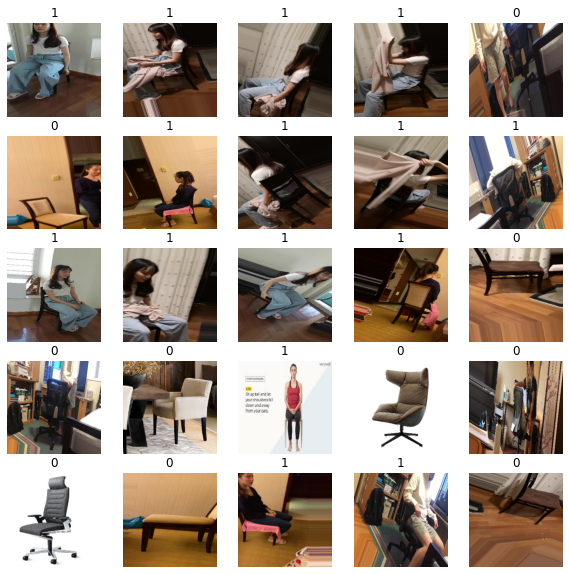

In [187]:
image_batch, label_batch = train_generator.next()
show_batch(image_batch, label_batch)

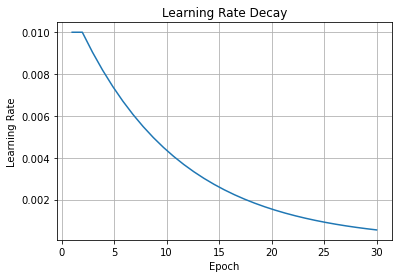

In [10]:
# Learning Rate Decay Graph

decay = []
def scheduler(epoch):
    learn_rate = config.MODEL_TRAIN_LEARN_RATE[0]
    total_epochs = config.MODEL_TRAIN_EPOCHS[0]
    
    if config.MODEL_TRAIN_DECAY:
        
        if epoch < config.MODEL_START_DECAY:
            value = learn_rate
            decay.append(value)
            return value
        
        else:
            if config.MODEL_DECAY_EXPONENTIAL: 
                value = learn_rate * tf.math.exp(
                        config.MODEL_PERCENT_DECAY * (config.MODEL_START_DECAY - epoch))
                
            if config.MODEL_DECAY_DROP:
                value = learn_rate * np.power(
                        config.MODEL_DROP_RATE, np.floor((1+epoch)/ config.MODEL_EPOCH_DROP))
                
            decay.append(value)
            return value
        
    else:
        return config.MODEL_TRAIN_LEARN_RATE[0]

for x in np.arange(0, config.MODEL_TRAIN_EPOCHS[0] + 1):
    scheduler(x)
    
plt.plot(np.linspace(1, config.MODEL_TRAIN_EPOCHS[0], config.MODEL_TRAIN_EPOCHS[0] + 1), decay)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Decay')
plt.grid()
plt.show()

In [11]:
model.compile(optimizer = Adam(lr = config.MODEL_TRAIN_LEARN_RATE[0]),
              loss = losses.BinaryCrossentropy(),
              metrics = ['binary_accuracy'])

In [12]:
# DIFFERENT CALLBACK FUNCTIONS

# Display Learning Rate Each Epoch
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * K.cast(iterations, K.dtype(decay)))
        print('\nEpoch Learning Rate: ', K.eval(lr_with_decay))
        
# Reduced learning rate when metric has stopped improving
reduced_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                               patience = 5, min_lr = 0, 
                               cooldown = 0, min_delta = 0.0001, verbose = 1)

# Early stopping when monitored quantity has stopped improving
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=20, 
                           verbose = 1, 
                           mode='auto')

# Tensorboard Callback
logdir = os.path.join('logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq = 1)

# Save Best File
model_name = datetime.datetime.now().strftime('%Y%m%d%H%M')
model_save = 'C:\\Users\\user\\model\\model_' + model_name + '.h5'
checkpoint = ModelCheckpoint(model_save, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=False,
                             mode='min',
                             period=1)


learning_rate_scheduler = LearningRateScheduler(scheduler, verbose = 0)
call_learning_rate = MyCallback()

history = model.fit(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = validation_generator,
                              validation_steps = STEP_SIZE_VALID,
                              epochs = config.MODEL_TRAIN_EPOCHS[0],
                              callbacks = [reduced_lr, 
                                           tensorboard_callback, 
                                           call_learning_rate,
                                           early_stop,
                                           checkpoint],
                              verbose = 1)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 152 steps, validate for 38 steps
Epoch 1/30
 40/152 [======>.......................] - ETA: 1:57 - loss: 3.3057 - binary_accuracy: 0.4891

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


151/152 [============================>.] - ETA: 0s - loss: 1.7685 - binary_accuracy: 0.4967
Epoch Learning Rate:  0.01

Epoch 00001: val_loss improved from inf to 262.38822, saving model to C:\Users\user\model_202005262132.h5
152/152 [==============================] - 146s 963ms/step - loss: 1.7617 - binary_accuracy: 0.4967 - val_loss: 262.3882 - val_binary_accuracy: 0.5724
Epoch 2/30
151/152 [============================>.] - ETA: 0s - loss: 0.7396 - binary_accuracy: 0.5068
Epoch Learning Rate:  0.01

Epoch 00002: val_loss improved from 262.38822 to 0.71420, saving model to C:\Users\user\model_202005262132.h5
152/152 [==============================] - 129s 848ms/step - loss: 0.7394 - binary_accuracy: 0.5066 - val_loss: 0.7142 - val_binary_accuracy: 0.5214
Epoch 3/30
151/152 [============================>.] - ETA: 0s - loss: 0.7155 - binary_accuracy: 0.5044
Epoch Learning Rate:  0.01

Epoch 00003: val_loss did not improve from 0.71420
152/152 [==============================] - 128s 842

Epoch 24/30
151/152 [============================>.] - ETA: 0s - loss: 0.0908 - binary_accuracy: 0.9703
Epoch Learning Rate:  0.0009999999

Epoch 00024: val_loss did not improve from 0.44299
152/152 [==============================] - 126s 828ms/step - loss: 0.0908 - binary_accuracy: 0.9703 - val_loss: 1.5522 - val_binary_accuracy: 0.5938
Epoch 25/30
151/152 [============================>.] - ETA: 0s - loss: 0.0779 - binary_accuracy: 0.9786
Epoch Learning Rate:  0.0009999999

Epoch 00025: val_loss did not improve from 0.44299
152/152 [==============================] - 125s 825ms/step - loss: 0.0777 - binary_accuracy: 0.9788 - val_loss: 0.5503 - val_binary_accuracy: 0.8084
Epoch 26/30
151/152 [============================>.] - ETA: 0s - loss: 0.0678 - binary_accuracy: 0.9793
Epoch Learning Rate:  0.0009999999

Epoch 00026: val_loss did not improve from 0.44299
152/152 [==============================] - 125s 825ms/step - loss: 0.0679 - binary_accuracy: 0.9792 - val_loss: 0.8997 - val_bina

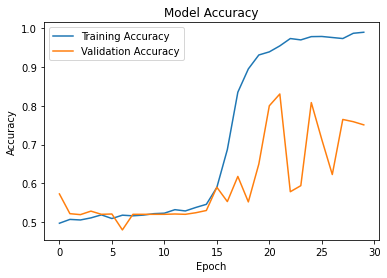

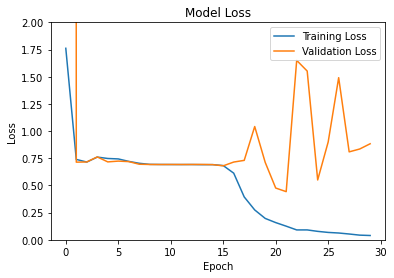

In [78]:
plt.figure(1)
plt.plot(history.history['binary_accuracy'], label = 'Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label = 'Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure(2)
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 2)
plt.legend()
plt.show()

In [101]:
print(model_save)
model = load_model(model_save)
pred_val = model.predict_generator(validation_generator,
                                   steps = STEP_SIZE_VALID,
                                   verbose = 1)
pred_val = pred_val > 0.5
val_acc_score = accuracy_score(validation_generator.classes[:config.MODEL_TRAIN_BATCH_SIZE*STEP_SIZE_VALID], pred_val)
print('Validation Accuracy Score: {0:0.4f}'.format(val_acc_score))

C:\Users\user\model\model_202005262132.h5
 1/38 [..............................] - ETA: 1:00

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\PIL\Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


38/38 [==============================] - 16s 414ms/step
Validation Accuracy Score: 0.8306


In [105]:
test_path = 'C:\\Users\\user\\Downloads'
test_generator = test_datagen.flow_from_directory(os.path.join(test_path, 'test1'),
                                                  target_size = (299,299),
                                                  color_mode = 'rgb',
                                                  seed = 724,
                                                  batch_size = 1,
                                                  class_mode = None,
                                                  shuffle = False)

STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 76 images belonging to 1 classes.


In [73]:
test_labels = []
for name in test_generator.filenames:
    if 'empty' in name or 'Empty' in name:
        test_labels.append(0)
    else:
        test_labels.append(1)
    
pred = model.predict_generator(test_generator,
                               steps = STEP_SIZE_TEST,
                               verbose = 1)

76/76 [==============================] - 2s 30ms/step


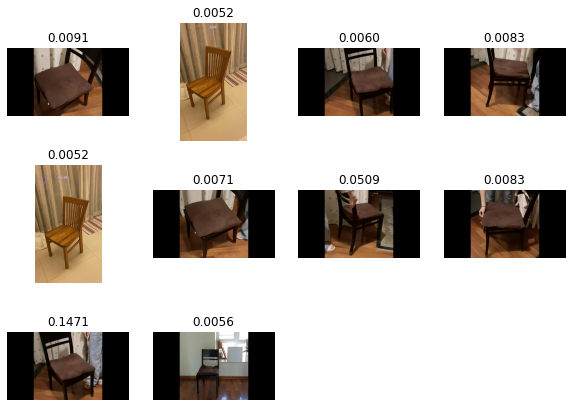

In [194]:
x = list(zip(list(pred.flatten()), test_generator.filenames))
random_batch = random.sample(x, 10)

plt.figure(figsize = (10,10))
for i in range(10):
    ax = plt.subplot(4,4,i+1)
    plt.title("{:.4f}".format(float(random_batch[i][0])))
    img = mpimg.imread(os.path.join(test_generator.directory, random_batch[i][1]))
    plt.imshow(img)
    plt.axis('off')

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:677: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


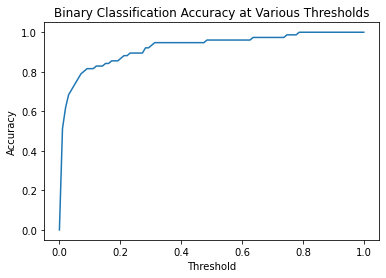

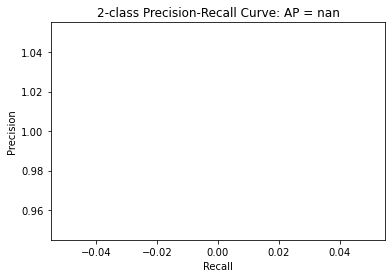

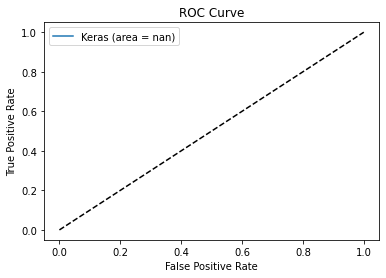

In [195]:
accuracy = []
for th in np.linspace(0, 1, 100):
    pred_labels = (pred > th)
    x = accuracy_score(pred_labels, test_labels)
    accuracy.append(x)
    
plt.figure(1)
plt.plot(np.linspace(0, 1, 100), accuracy)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Binary Classification Accuracy at Various Thresholds')

plt.figure(2)
precision, recall, thresholds = precision_recall_curve(test_labels, pred)
average_precision = average_precision_score(test_labels, pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall Curve: AP = ''{0:0.2f}'.format(average_precision))

fpr_keras, tpr_keras, thersholds_keras = roc_curve(test_labels, pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label = 'Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'best')
plt.show()

plt.show()

Confusion Matrix :
[[73  3]
 [ 0  0]]
Accuracy Score : 0.9605263157894737
Report : 
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        76
           1       0.00      0.00      0.00         0

    accuracy                           0.96        76
   macro avg       0.50      0.48      0.49        76
weighted avg       1.00      0.96      0.98        76



c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


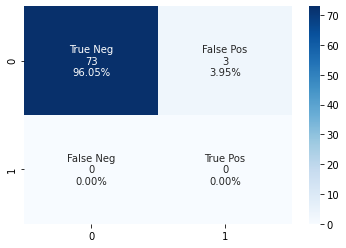

In [196]:
threshold = 0.5
pred_labels = (pred > threshold).astype(int).flatten()

cf_matrix = confusion_matrix(test_labels, pred_labels) 
  
print('Confusion Matrix :')
print(cf_matrix) 
print('Accuracy Score :', accuracy_score(test_labels, pred_labels))
print('Report : ')
print(classification_report(test_labels, pred_labels))

plt.figure(1)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt='', cmap = 'Blues')
plt.show()

In [ ]:
# Save prediction results with filename to csv
import re

if os.listdir('C:\\Users\\user\\results'): 
    sequence_number = int(re.findall('\d+', max(os.listdir('C:\\Users\\user\\results')))[0]) + 1
else:
    sequence_number = 1

d = {'Filenames': test_generator.filenames, 'Prediction_' + str(sequence_number): pred_labels}
results = pd.DataFrame(data = d)
file_name = 'C:\\Users\\user\\results\\results_' + str(sequence_number) + '.csv'
results.to_csv(file_name, index = False, header = True)
print(file_name)